# Computing Transmission Spectroscopy

Computing transmission spectroscopy is pretty much the same deal as the thermal emission/reflected light. There are just a couple tweaks we will have to make in order to make sure we have the full set of info.


In [1]:
import numpy as np
import pandas as pd

#picaso
from picaso import justdoit as jdi
from picaso import justplotit as jpi

#plotting
jpi.output_notebook()

Loading BokehJS ...

We will use new Hot Jupiter template to guide us through the exercise.

In [2]:
opa = jdi.opannection(wave_range=[0.6,5])

case1 = jdi.inputs()

case1.phase_angle(0)


#here we are going to have to specify gravity through R and M since we need it in the Flux calc
case1.gravity(mass=1, mass_unit=jdi.u.Unit('M_jup'),
              radius=1.2, radius_unit=jdi.u.Unit('R_jup'))

#here we are going to have to specify R as well
case1.star(opa, 4000,0.0122,4.437,radius=0.7, radius_unit = jdi.u.Unit('R_sun') )

#atmo
case1.atmosphere(filename = jdi.HJ_pt(), sep=r'\s+')

## Reference Pressure

The reference pressure sets the level of your radius. It is needed to compute the altitude and altitude-dependent gravity. PICASO default is 1 bar but for gas giant calculations its more common to use 10 bar. This is easy to swap. If you are running terrestrial planet models you want your reference pressure to be the highest pressure in your user-specified grid.

In [3]:
case1.approx(p_reference=10)

## Return ``PICASO`` Full Output

In [4]:
df= case1.spectrum(opa, full_output=True,calculation='transmission') #note the new last key

wno, rprs2  = df['wavenumber'] , df['transit_depth']
wno, rprs2 = jdi.mean_regrid(wno, rprs2, R=150)
full_output = df['full_output']

Here we are getting a few error messages that our example `HJ_cld` had some unrecognized molecules. Looking them over, this looks okay! `x` is not a molecule, and neither is `Kzz`. The code has accurately identified non-molecules in our input.

## Analyzing Transit Spectroscopy Output


### Can use the same plotting functionality as reflected light


In [5]:
jpi.show(jpi.pt(full_output,plot_width=500))
jpi.show(jpi.mixing_ratio(full_output,plot_width=500))

### Standard (Rp/Rs)^2

In [6]:
jpi.show(jpi.spectrum(wno,rprs2*1e6,plot_width=500))

## See Molecular Contribution of Spectra

Sometimes it is helpful to compute your spectra by excluding contribution from certain molecules. This will help you see where they affect the spectra. You can do this by using the `exclude_mol` feature, which excludes the opacity of a certain molecule without changing the calculation.

In [7]:
#atmo
w,f,l =[],[],[]
for iex in ['CH4','H2O','CO2',None]:
    case1.atmosphere(filename = jdi.HJ_pt(),exclude_mol=iex, sep=r'\s+')
    df= case1.spectrum(opa, full_output=True,calculation='transmission') #note the new last key
    wno, rprs2  = df['wavenumber'] , df['transit_depth']
    wno, rprs2 = jdi.mean_regrid(wno, rprs2, R=150)
    w +=[wno]
    f+=[rprs2]
    if iex==None:
        leg='all'
    else:
        leg = f'No {iex}'
    l+=[leg]
jpi.show(jpi.spectrum(w,f,legend=l))

## Adding Grey Cloud

If you want to test the observability of your features against varying strengths of cloud optical depth, you can use the `cloud` box model function

Remember:

- `p` is the maximum cloud pressure in log. Max Pressure = 10^p bars
- `dp` is the thickness in log. Minimum Pressure = 10^(p-dp) bars
- In order to simulate an optically thick cloud deck, set `opd` arbitrarily large (>1)
- In transit, the asymmetry and single scattering albedo are not used and can be set to anything between 0-1


In [8]:
case1.clouds(p = [1], dp=[4], opd=[1], g0=[0], w0=[0])

df_gry= case1.spectrum(opa, full_output=True,calculation='transmission') #note the new last key

wno, rprs2_gry  = df_gry['wavenumber'] , df_gry['transit_depth']
wno, rprs2_gry = jdi.mean_regrid(wno, rprs2_gry, R=150)
full_output_gry = df_gry['full_output']

jpi.show(jpi.spectrum([wno, wno],[1e6*(rprs2-np.mean(rprs2))
                              , (rprs2_gry-np.mean(rprs2_gry))*1e6],
                  legend=['Cloud free','Grey cloud'],
                  plot_width=500))

## Adding Cloud From Model Output

In [9]:
case1.clouds(filename = jdi.HJ_cld(), sep=r'\s+')

df_model= case1.spectrum(opa, full_output=True,calculation='transmission') #note the new last key

wno, rprs2_model = df_model['wavenumber'] , df_model['transit_depth']
wno, rprs2_model = jdi.mean_regrid(wno, rprs2_model, R=150)
full_output_model = df_model['full_output']

jpi.show(jpi.spectrum([wno, wno,wno],[1e6*(rprs2-np.mean(rprs2))
                              , (rprs2_gry-np.mean(rprs2_gry))*1e6
                             , (rprs2_model-np.mean(rprs2_model))*1e6],legend=['Cloud Free','Grey Cloud','Virga Cloud'],
                  plot_width=500))

## Adding Arbitrary Rayleigh Scattering

All models will include Rayleigh scattering that is computed based on the atmospheric composition. H$_2$ gas giants would have Rayleigh scattering from hydrogen, Earth-like composition planets would have Rayleigh scattering from nitrogen. Several hot Jupiter observations have revealed slopes that are enhanced, relative to Rayleigh.

To simulate an enhanced scattering slope you can add your own parameterized opacity directly to the cloud routine.

In [10]:
alpha = 4.5 #slope dependence for arbitrary rayleigh
ref_wave = 0.3 #reference wave to set at what wavelength tau=ref_tau
ref_tau = 5e-2

wno_cld = jdi.get_cld_input_grid()
wave= 1e4/wno_cld
enhanced_rayleigh_opd =  np.concatenate([ref_tau*(wave/ref_wave)**(-alpha) for i in range(case1.nlevel-1)])

In [11]:
case1.clouds(df=pd.DataFrame({
    'opd':enhanced_rayleigh_opd,
    'g0':enhanced_rayleigh_opd*0,
    'w0':enhanced_rayleigh_opd*0
}))

df_ray= case1.spectrum(opa, full_output=True,calculation='transmission') #note the new last key

wno, rprs2_ray = df_ray['wavenumber'] , df_ray['transit_depth']
wno, rprs2_ray = jdi.mean_regrid(wno, rprs2_ray, R=150)
full_output_ray = df_ray['full_output']

jpi.show(jpi.spectrum([wno, wno],[1e6*(rprs2-np.mean(rprs2))
                             , (rprs2_ray-np.mean(rprs2_ray))*1e6],
                  legend=['H2 Rayleigh','Enhanced Rayleigh'],
                  plot_width=600,x_axis_type='log'))

## Transmission Contribution Function

The transmission contribution function allows you to determine what pressures your model is sensitive to. The transmission contribution function is defined by Eqn. 8 [Molliere et al 2019](https://arxiv.org/pdf/1904.11504.pdf).

Note that this will take a little to run as it is effectively re-computing a transmission spectrum with each layer removed. By comparing the original spectrum to a spectrum with the layer removed, we can see how much that layer contributes to the overall spectrum.

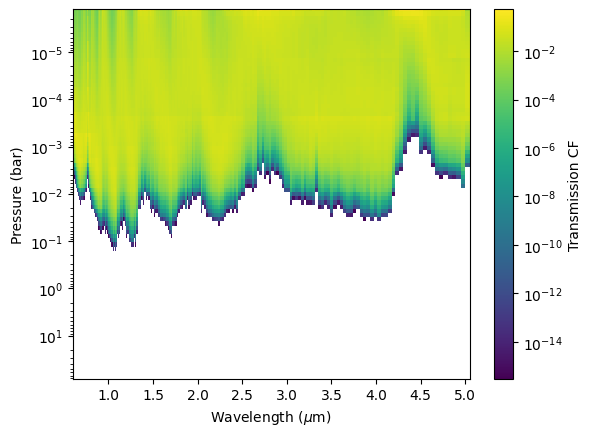

In [12]:
full_output=df['full_output']
fig, ax, um, CF_bin = jpi.transmission_contribution(full_output ,R=100)

### Customize Transmission Contribution plot

<>:9: SyntaxWarning: invalid escape sequence '\m'
<>:9: SyntaxWarning: invalid escape sequence '\m'
/tmp/ipykernel_57544/473936513.py:9: SyntaxWarning: invalid escape sequence '\m'
  ax.set_xlabel('Wavelength ($\mu$m)')


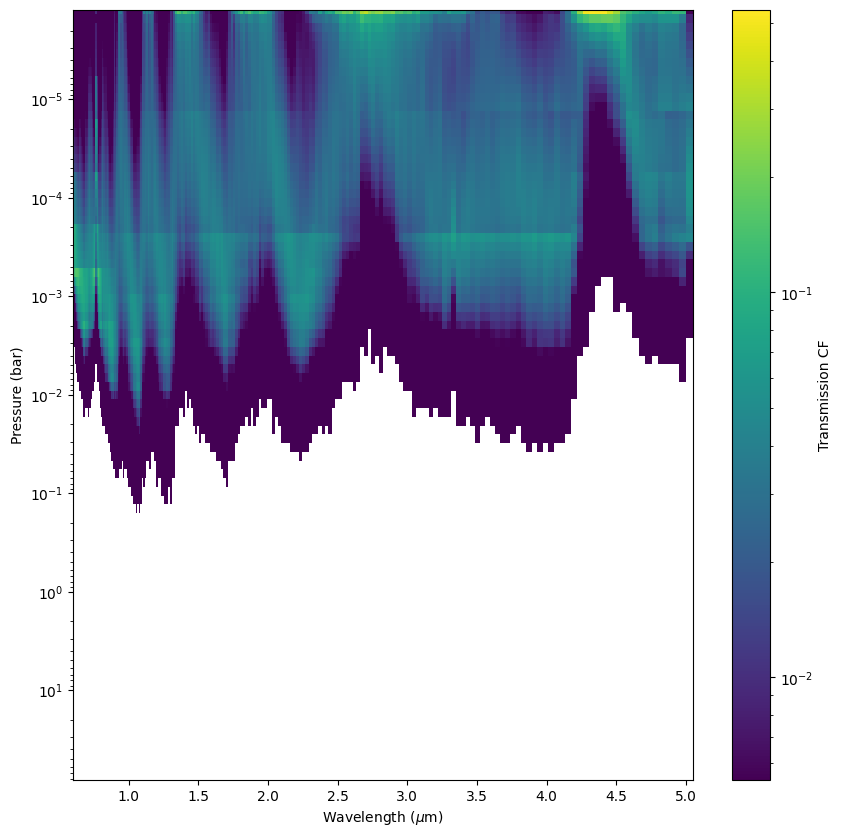

In [13]:
fig, ax = jpi.plt.subplots(figsize=(10, 10))

smap = ax.pcolormesh(um, full_output['layer']['pressure'], CF_bin, norm=jpi.colors.LogNorm(vmax=np.max(CF_bin)
                                                                                  , vmin =np.max(CF_bin)/100 ))
ax.set_ylim(np.max(full_output['layer']['pressure']),
            np.min(full_output['layer']['pressure']))
ax.set_yscale('log')
ax.set_ylabel('Pressure (bar)')
ax.set_xlabel('Wavelength ($\mu$m)')
jpi.plt.colorbar(smap, label='Transmission CF')